In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3"

In [2]:
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import NuSVC, LinearSVC, SVC
import numpy as np
import pandas as pd
import math
import pickle
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import h5py
import random
import cv2
from tqdm import tqdm
from collections import Counter
from utils import *
# from datasets import *
# from models import *
from typing import List
import albumentations as A
from albumentations.pytorch import ToTensorV2

/home/cwbennie/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/cwbennie/anaconda3/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Examples of Images from MURA

(256, 256, 3)

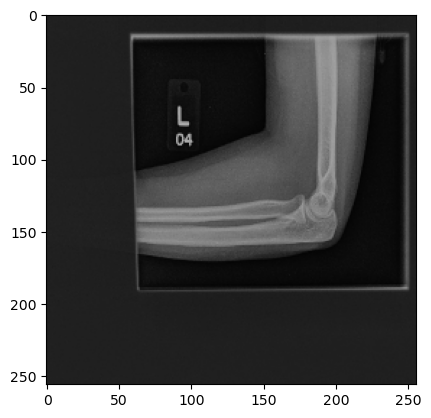

In [2]:
pth = '/home/cwbennie/data/MURA_256/train/XR_ELBOW/patient04082/study1_negative/image1.png'
im = cv2.imread(str(pth))
plt.imshow(im)
im.shape

(425, 512, 3)

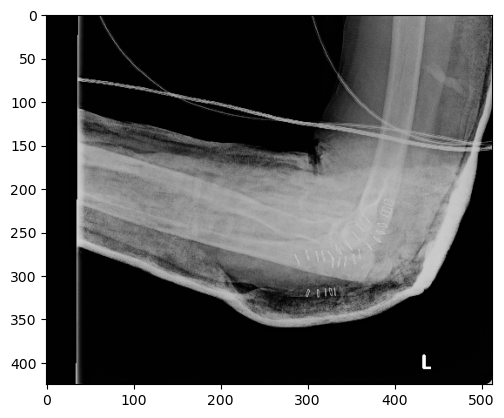

In [3]:
pth = '/home/cwbennie/data/MURA-v1.1/train/XR_ELBOW/patient05259/study1_positive/image1.png'
im = cv2.imread(str(pth))
plt.imshow(im)
im.shape

In [3]:
def crop(im, r, c, target_r, target_c):
	return im[r:target_r, c:target_c]

def center_crop_square(im):
    """ Returns a center crop of an image"""
    # get shape of the image
    r,c,*_ = im.shape
    # pick the minimum size to use to create the square crop
    min_sz = min(r,c)
    # calculate start row/column values using minimum size
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def get_a_crop(path, sz=250):
    im = cv2.imread(str(path))
    return cv2.resize(center_crop_square(im), (sz, sz))

In [4]:
def resize_mura_images(path: Path, output_path: Path, target_size=320):
    os.makedirs(output_path, exist_ok=True)
    for dirpath, dirnames, files in os.walk(path):
        for file in files:
            if file.endswith('png'):
                im_file = os.path.join(dirpath, file)
                try:
                    img = cv2.resize(cv2.imread(im_file), (target_size, target_size))
                    rel_path = os.path.relpath(dirpath, path)
                    target_dir = os.path.join(output_path, rel_path)
                    os.makedirs(target_dir, exist_ok=True)
                    output_file = os.path.join(target_dir, file)
                    cv2.imwrite(str(output_file), img)
                except Exception as e:
                    print(f'Empty image: {e}')
                

In [4]:
# Run this just once to resize all images to 320 x 320

# mura_pth = Path('/home/cwbennie/data/MURA-v1.1')
# resize_path = Path('/home/cwbennie/data/MURA_320')
# resize_mura_images(mura_pth, resize_path)

Empty image: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Empty image: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Empty image: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Empty image: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [6]:
ims, labels, categories = get_mura_images(Path('/home/cwbennie/data/MURA-v1.1/'))

In [7]:
print(len(ims), len(labels), len(categories))

14656 14656 14656


In [8]:
print(ims[0], labels[0], categories[0])

[array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [61, 61, 61],
        [65, 65, 65],
        [74, 74, 74]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [61, 61, 61],
        [65, 65, 65],
        [74, 74, 74]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [61, 61, 61],
        [64, 64, 64],
        [73, 73, 73]]], dtype=uint8), array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
 

In [9]:
del ims
del labels
del categories

In [47]:
path = '/home/cwbennie/data/MURA-v1.1/'
resize_pth = '/home/cwbennie/data/MURA_256/'
# resize_mura_images(path, resize_pth, target_size=256)

Empty image: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Empty image: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Empty image: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Empty image: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



(256, 256, 3)

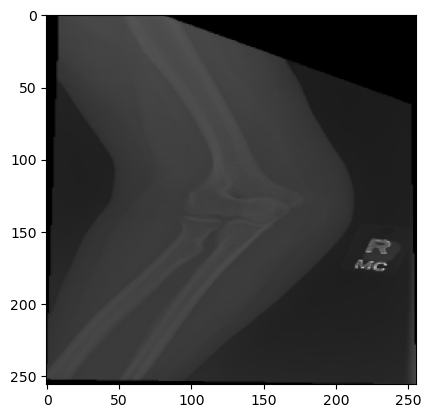

In [48]:
tst = '/home/cwbennie/data/MURA_256/valid/XR_ELBOW/patient11817/study1_positive/image1.png'
im = cv2.imread(str(tst))
plt.imshow(im)
im.shape

(512, 243, 3)

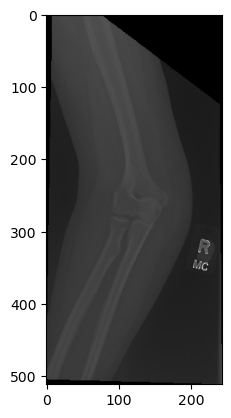

In [39]:
tst = '/home/cwbennie/data/MURA-v1.1/valid/XR_ELBOW/patient11817/study1_positive/image1.png'
im = cv2.imread(str(tst))
plt.imshow(im)
im.shape

(1024, 1024, 3)

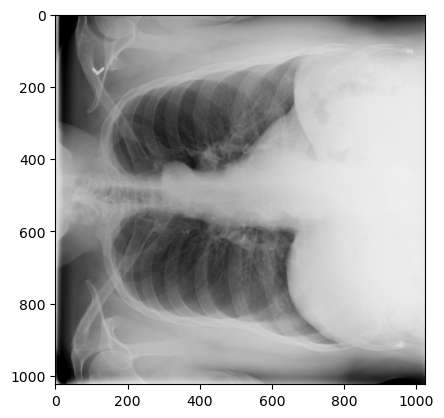

In [3]:
# example of rotated image
rot_im = np.rot90(im, 1)
plt.imshow(rot_im)
rot_im.shape

## Create Datasets and Dataloaders for MURA classification task

In [5]:
def update_image_dict(im_file: Path, image_dict: dict):
    img = cv2.imread(str(im_file))
    if img is not None:
        # img = img.astype(np.float32)
        if image_dict.get('images'):
            image_dict['images'].append(im_file)
        else:
            image_dict['images'] = [im_file]


def get_mura_images(path: Path):
    images = list()
    labels = list()
    categories = list()
    for dirpath, _, files in os.walk(Path(path)):
        for file in files:
            if file.endswith('.png'):
                im_file = os.path.join(dirpath, file)
                img = cv2.imread(str(im_file))
                if img is not None:
                    images.append(im_file)
                    label = 1 if 'positive' in str(dirpath) else 0
                    labels.append(label)
                    cat = get_mura_category(str(dirpath))
                    categories.append(cat)
    return images, labels, categories

def transform_image(image, transform_pipe: A.Compose):
    img = cv2.imread(str(image))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    augmented = transform_pipe(image=img)
    return augmented['image']

def get_category_counts(labels: list, categories: list):
	count_dict = dict()
	neg_dict = dict()
	for i in range(len(labels)):
		if labels[i] == 0:
			neg_dict[categories[i]] = neg_dict.get(categories[i], 0) + 1
		else:
			count_dict[categories[i]] = count_dict.get(categories[i], 0) + 1
	pos_weights = {key: count_dict[key] / (count_dict[key] + neg_dict[key])
				for key in count_dict.keys()}
	neg_weights = {key: neg_dict[key] / (count_dict[key] + neg_dict[key])
				for key in count_dict.keys()}
	return pos_weights, neg_weights

In [6]:
class MuraData(Dataset):
    def __init__(self, dir_path: Path, transform: bool = False):
        self.image_dir = dir_path
        self.images, self.labels, self.cats = get_mura_images(self.image_dir)
        if transform:
            self.transforms = A.Compose([
                # A.Resize(320, 320),
                A.HorizontalFlip(p=0.5),
                A.Rotate(limit=30),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
        else:
            self.transforms = A.Compose([
                # A.Resize(320, 320),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])
        self.pos_weights, self.neg_weights = get_category_counts(self.labels,
                                                                 self.cats)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        images = self.images[index]
        image_arr = transform_image(images, self.transforms)
        pos_category_wt = self.pos_weights[self.cats[index]]
        neg_category_wt = self.neg_weights[self.cats[index]]
        return image_arr, self.labels[index], (pos_category_wt, neg_category_wt)

In [7]:
pth = Path('/home/cwbennie/data/MURA_320/train')
mura_train = MuraData(pth, transform=True)

In [8]:
class MURALoss(torch.nn.Module):
    def __init__(self, pos_weights: dict = None, neg_weights: dict = None):
        super(MURALoss, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, predictions: torch.Tensor, targets: torch.Tensor,
                weights: tuple):
        loss_pos_wts = torch.Tensor(weights[0]).to(self.device)
        loss_neg_wts = torch.Tensor(weights[1]).to(self.device)
        loss = -(loss_pos_wts * targets * predictions.log() +
                loss_neg_wts * (1 - targets) * (1 - predictions).log())
        return loss.mean()

In [9]:
from sklearn.metrics import roc_auc_score

def compute_auc(probs, y_vals):
	probs = np.vstack(probs)
	y_vals = np.vstack(y_vals)
	return roc_auc_score(y_true=y_vals, y_score=probs)

In [22]:
def mura_model_eval(model: nn.Module, valid_dl: DataLoader,
                    criterion: MURALoss, test=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    predictions = list()
    y_actuals = list()
    probs = list()
    losses = list()
    model.eval()
    for x_val, y_val, weights in valid_dl:
        out = model(x_val.to(device))
        y_val = y_val.to(device).float()
        loss = criterion(out.squeeze(), y_val, weights)
        # loss = F.binary_cross_entropy(out.squeeze(), y_val)
        losses.append(loss.item())
        preds = out.squeeze()
        predictions.extend(preds.cpu().detach().numpy())
        probs.extend(out.cpu().detach().numpy())
        y_actuals.extend(y_val.cpu().numpy())
    auc_score = compute_auc(probs=probs, y_vals=y_actuals)
    if not test:
        return np.mean(losses)
    return np.mean(losses), auc_score

In [19]:
# function to fine-tune ResNet on the sonar images
def train_mura_model(model: nn.Module, optimizer: torch.optim.Adam,
                     train_dl, valid_dl, epochs: int = 25, track_loss=False,
                     lr_scheduler=None, criterion: torch.nn.Module = MURALoss,
                     **kwargs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optimizer(parameters, lr=0.0001, betas=(0.9, 0.999))
    if lr_scheduler is not None:
        scheduler = get_scheduler(name=lr_scheduler, optimizer=optimizer,
                                  epochs=epochs, **kwargs)
    epoch_losses = list()
    auc_scores = list()
    val_losses = list()
    criterion = criterion.to(device)

    # train the model for the given number of epochs
    for i in range(epochs):
        # losses = list()
        model.train()
        total = 0
        sum_loss = 0
        for img, y, weights in train_dl:
            batch = y.shape[0]
            img = img.to(device).float()
            y = y.to(device).float()
            out = model(img)
            loss = criterion(out.squeeze(), y, weights)
            # loss = F.binary_cross_entropy(out.squeeze(), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # losses.append(loss.item())
            sum_loss += batch * (loss.item())
            total += batch
        train_loss = sum_loss / total
        epoch_losses.append(train_loss)
        print(f'Epoch finished: Loss -> {train_loss}')
        if valid_dl:
            val_loss, epoch_auc = mura_model_eval(model, valid_dl,
                                                  criterion=criterion,
                                                  test=True)
            val_losses.append(val_loss)
            auc_scores.append(epoch_auc)
            print(f'Epoch Validation: Loss -> {val_loss}\nAUC Score -> {epoch_auc}\n')
        if lr_scheduler is not None:
            scheduler.step()
    if track_loss:
        return epoch_losses, val_losses

In [13]:
class MURANet(nn.Module):
    def __init__(self, training=False, output=1):
        super(MURANet, self).__init__()
        if not training:
            densenet = models.densenet121(weights='DEFAULT')
            # for param in densenet.parameters():
            #     param.requires_grad = False
        else:
            densenet = models.densenet121(weights='DEFAULT')
        layers = list(densenet.children())[0]
        self.base_densenet = nn.Sequential(*layers)
        self.fc = nn.Linear(1024, output)

    def forward(self, x):
        img = torch.relu(self.base_densenet(x))
        img = nn.AdaptiveAvgPool2d((1, 1))(img)
        img = img.view(img.size(0), -1)
        img = self.fc(img)
        img = torch.sigmoid(img)
        return img

In [14]:
train_dl = DataLoader(mura_train, batch_size=8, shuffle=True)

In [15]:
mura_test = MuraData(Path('/home/cwbennie/data/MURA_320/valid'))
valid_dl = DataLoader(mura_test, batch_size=8, shuffle=False)

In [23]:
tst_net = MURANet()
mura_loss = MURALoss()
train_mura_model(tst_net, train_dl=train_dl, optimizer=torch.optim.Adam,
				 valid_dl=valid_dl, epochs=10, criterion=mura_loss,
				 lr_scheduler='OneCycle', max_lr=0.0005, steps_per_epoch=len(train_dl))

Epoch finished: Loss -> 0.505756598112506
Epoch Validation: Loss -> 0.4631735143810511
AUC Score -> 0.8667584130232777

Epoch finished: Loss -> 0.4544451271702585
Epoch Validation: Loss -> 0.44303314603865146
AUC Score -> 0.8770320445714779

Epoch finished: Loss -> 0.42650629372745463
Epoch Validation: Loss -> 0.41339751074556264
AUC Score -> 0.8905399312294404

Epoch finished: Loss -> 0.40867690355641456
Epoch Validation: Loss -> 0.4128976662014611
AUC Score -> 0.8947779071636653

Epoch finished: Loss -> 0.39002172350300524
Epoch Validation: Loss -> 0.4143010005168617
AUC Score -> 0.8894095690665789

Epoch finished: Loss -> 0.37243563900532684
Epoch Validation: Loss -> 0.4352969765197486
AUC Score -> 0.886488584636014

Epoch finished: Loss -> 0.3543497539378202
Epoch Validation: Loss -> 0.41953114490956067
AUC Score -> 0.8930096333674442

Epoch finished: Loss -> 0.33902322254885514
Epoch Validation: Loss -> 0.419964757876005
AUC Score -> 0.8944679691512678



KeyboardInterrupt: 

In [48]:
def save_model(model: nn.Module, model_name: str):
    # function to save model weights
    path = './models/'+model_name
    torch.save(model.state_dict(), path)

In [50]:
save_model(tst_net, 'onecycle_89_auc')